In [14]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')
import scipy.stats
import statsmodels.stats.multitest as mt
from matplotlib.lines import Line2D

import shared_functions

In [15]:
data = joblib.load('joblib/catsNdogs_data.joblib')

In [16]:
def phylums_mv(taxa_df,info,level,draw=False):
    df = taxa_df.merge(info,left_index=True,right_index=True)
    z = df.groupby(['project_name','Host','Host_type']).agg('median')
    def _mw(df2):
        cat = df2.index.get_level_values(2)
        x = list(df2[cat.isin(['human'])])
        y = list(df2[cat.isin(['pet'])])
        try:
            (mw,mw_pval) = scipy.stats.mannwhitneyu(x,y,alternative="two-sided")
            return(mw_pval)
        except:
            return(None)
    phylum_mw_test = z.apply(_mw)
    all_phylums = list(phylum_mw_test.index)
    phylum_mw_test = phylum_mw_test.dropna()
    rj_holm,corr_pvalue_holm,c1,c2 = mt.multipletests(phylum_mw_test, method='holm')
    rj_fdr,corr_pvalue_fdr,c1,c2 = mt.multipletests(phylum_mw_test, method='fdr_bh')
    phylum_mw_test = pd.DataFrame(phylum_mw_test,columns=['mw_pvalue'])
    phylum_mw_test['corr_pvalue_holm'] = corr_pvalue_holm
    phylum_mw_test['rj_holm'] = rj_holm
    phylum_mw_test['corr_pvalue_fdr'] = corr_pvalue_fdr
    phylum_mw_test['rj_fdr'] = rj_fdr
    phylum_mw_test['level']= level
    if (draw):
        draw_cols = list(phylum_mw_test[rj_holm].index)
        draw_boxplot_by_projects(data_phylums[draw_cols],info,shared_functions.get_tax_name_by_level(level))
    res_holm = list(phylum_mw_test[rj_holm].index)
    res_fdr = list(phylum_mw_test[rj_fdr].index)
    #print(phylum_mw_test)
    return(df,(res_holm,res_fdr,all_phylums),phylum_mw_test)

In [17]:
def draw_boxplot_by_projects(data_phylums,info,name):
    df = data_phylums.merge(info,left_index=True,right_index=True)
    df_melted = pd.melt(df,id_vars=['project_name','Host','Host_type'])
    df_melted['last_tax'] = df_melted.variable.apply(lambda x: x.split(';')[-1])
    plt.figure(figsize=(20,7))
    ax = plt.gca()
    g1 = sns.boxplot(y="value", x="last_tax", hue="project_name",palette=['r']*12+['b']*13,
                    data=df_melted,whis = [5,95],showfliers=False,boxprops=dict(alpha=.8))
    legend_elements = [Line2D([0], [0], color='r', label='cats and dogs projects'),
                       Line2D([0], [0], color='b', label='human projects')]
    g1.legend(loc='center', bbox_to_anchor=(0.5, 1.1), handles=legend_elements, ncol = 2)
    plt.xticks(rotation=45) 
    ax.set_xlabel('')
    ax.set_ylabel('taxon portion of the total')
    plt.title(name)
    plt.show()

## All phylums distribution by projects
Note the outliers

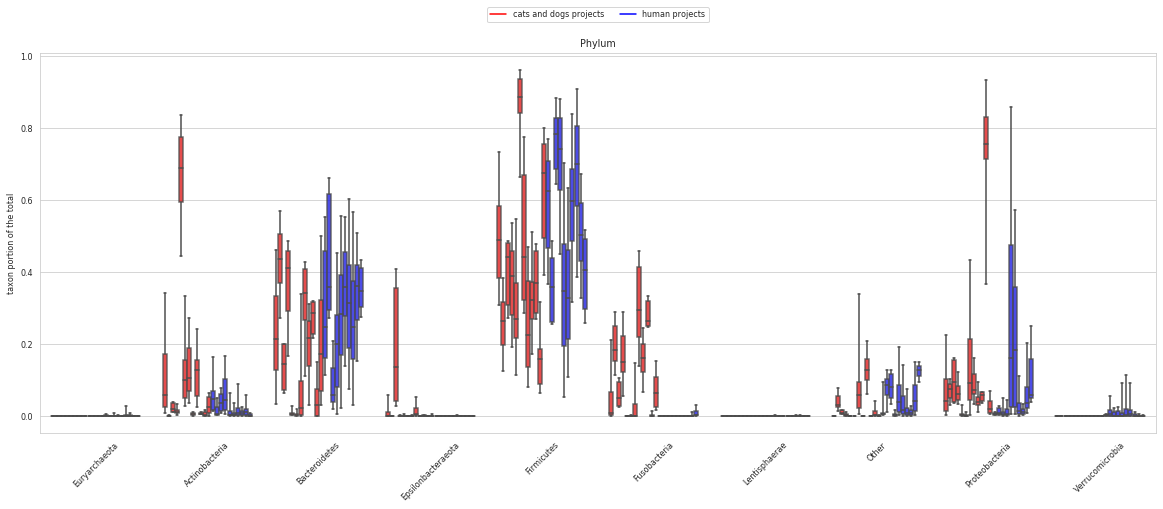

In [18]:
data_phylums = data.get_taxa(1,True)
draw_boxplot_by_projects(data_phylums,data.info,shared_functions.get_tax_name_by_level(1))

## MW test for Chao diversity index

In [19]:
df = data.info.merge(data.chao,left_index=True,right_index=True)
z = df.groupby(['project_name','Host_type'])['mean_chao'].agg('median').to_frame().reset_index()
x = z.loc[z.Host_type=='pet','mean_chao']
y = z.loc[z.Host_type=='human','mean_chao']
z.set_index(keys = ['project_name','Host_type'],inplace=True)
z.columns = ['chao index (project median)']
display(z.sort_values(['Host_type','chao index (project median)']))
print('MW two-sided test pet vs. human')
scipy.stats.mannwhitneyu(x,y,alternative="two-sided")

,,chao index (project median)
project_name,Host_type,
29404425,human,72.500000
31027508,human,85.721429
28195358,human,122.498990
29795809,human,146.474639
26179554,human,155.795904
qiita_10928,human,163.270492
28179361,human,213.372159
28429209,human,215.128933
25417156,human,226.500225


MW two-sided test pet vs. human


MannwhitneyuResult(statistic=42.0, pvalue=0.24853467917305805)

## MW significant taxa (Holm correction ) on each level, from Phylum to Genus

In [20]:
bf = {}
mwres = pd.DataFrame()
for i in range(1,6):
    data_tax = data.get_taxa(i,True)
    x,y,z = phylums_mv(data_tax,data.info,i,False)
    bf[(i,'best_holm')] = (list(pd.unique(y[0])),False)
    bf[(i,'best_fdr')] = (list(pd.unique(y[1])),False)
    bf[(i,'all')] = (list(pd.unique(y[2])),True)
    tax = shared_functions.get_tax_name_by_level(i)
    print(tax,':',len(pd.unique(y[0])),len(pd.unique(y[1])),'significant out of',len(pd.unique(y[2])))
    mwres = pd.concat([mwres,z[z.rj_holm|z.rj_fdr]])

Phylum : 2 2 significant out of 10
Class : 3 4 significant out of 18
Order : 2 4 significant out of 29
Family : 6 14 significant out of 55
Genus : 12 32 significant out of 138


In [21]:
mwres = mwres.reset_index().rename(columns={'index': 'full_tax_name'})
mwres['last_tax_name'] = mwres.full_tax_name.apply(lambda x: x.split(';')[-1])
mwres['tax_level'] = mwres.level.apply(shared_functions.get_tax_name_by_level)
mwres.sort_values(['level','corr_pvalue_holm','corr_pvalue_fdr'],inplace=True)
mwres_write = mwres[['full_tax_name','last_tax_name','tax_level','mw_pvalue',
               'corr_pvalue_holm','rj_holm','corr_pvalue_fdr','rj_fdr']]
mwres_write.to_csv('results/catsNdogs_SupplementaryTable3.txt',index=False,sep='\t')

In [22]:
tax = data_tax.T.reset_index()['index'].to_frame()
tax = pd.concat([tax,tax.apply(lambda x: x[0].split(';'),axis=1,result_type='expand')],axis=1)
tax.set_index('index',inplace=True)
tax.columns = list(map(shared_functions.get_tax_name_by_level,list(tax.columns)))
tax.index.name = 'tax_full_name'
#tax.to_csv('results/catsNdogs_Table3_1_taxa_to_mark.txt',sep='\t')

In [23]:
joblib.dump(bf,'joblib/catsNdogs_mw_bf.joblib')

['joblib/catsNdogs_mw_bf.joblib']

In [24]:
def draw2(df_melted,x,log=True):
    n = len(x)
    if (n==1):
        ncol,nrow = 1,1
    elif (n==2):
        ncol,nrow = 2,1
    elif (n==3):
        ncol,nrow = 3,1
    elif (n==4):
        ncol,nrow = 2,2
    else:
        ncol = 3
        nrow = int(np.ceil(n/ncol))
    print(n,ncol,nrow)
    plt.rcParams.update({'font.size': 8})
    fig, axs = plt.subplots(nrow,ncol,figsize=(2.21*ncol,2.1*nrow),sharey=True)
    k = 0
    axs = axs.reshape(nrow,ncol)
    for i in range(nrow):
        for j in range(ncol):
            tax_i = x[k]
            #axs[i][j].annotate('A',xy=(-0.15,0.95),xycoords='axes fraction',**{'size':12})
            if (log==True):
                axs[i][j].set_yscale('symlog',linthreshy=1e-3)
            df_melted_i = df_melted[df_melted.variable==tax_i]
            g1 = sns.boxplot(y="value", x="last_tax", hue="project_name",palette=['r']*12+['b']*10,
                    data=df_melted_i,whis = [5,95],showfliers=False,boxprops=dict(alpha=.8),ax=axs[i][j],
                            linewidth=0.8)
            axs[i][j].get_legend().remove()
            axs[i][j].set_xlabel('')
            if ((i==0)&(j==(ncol-1))):
                legend_elements = [Line2D([0], [0], color='r', label='pet projects'),
                           Line2D([0], [0], color='b', label='human projects')]
                axs[i][j].legend(loc = 'upper right',bbox_to_anchor=(1.04, 1.2),
                                 handles=legend_elements, ncol = 2,frameon=False)
            axs[i][j].set_ylabel('')
            k = k + 1
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(b=None)
    #plt.xlabel("common X")
    plt.ylabel("Taxon abundance/frequency",labelpad=10)
    #plt.savefig(name, dpi = 300, bbox_inches='tight')

6 3 2


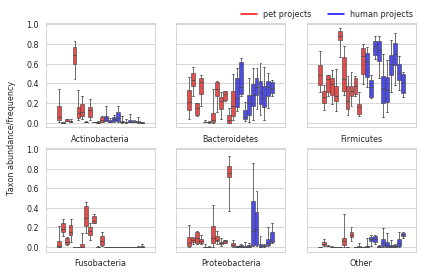

In [25]:
data_tax = data.get_taxa(1,True)
x = ['Bacteria;Actinobacteria','Bacteria;Bacteroidetes','Bacteria;Firmicutes',
     'Bacteria;Fusobacteria','Bacteria;Proteobacteria','Bacteria;Other']
data_phylums = data_tax.loc[:,x]
df = data_phylums.merge(data.info,left_index=True,right_index=True)
df_melted = pd.melt(df,id_vars=['project_name','Host','Host_type'])
df_melted['last_tax'] = df_melted.variable.apply(lambda x: x.split(';')[-1])
draw2(df_melted,x,False)
name = 'pics/SupplementaryFigure1.pdf'
plt.savefig(name, dpi = 300, bbox_inches='tight')

2 2 1
3 3 1
2 2 1
6 3 2
12 3 4


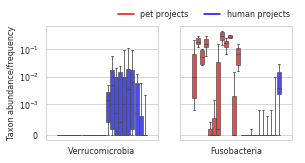

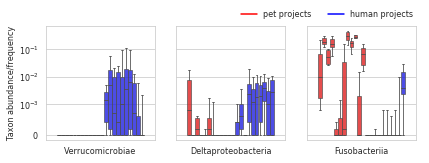

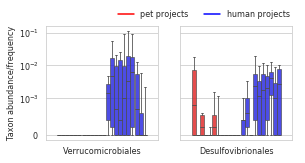

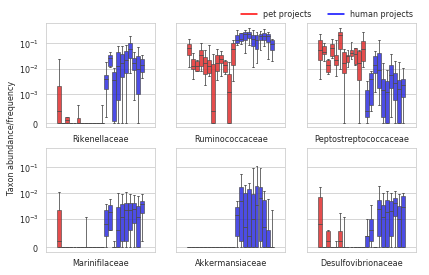

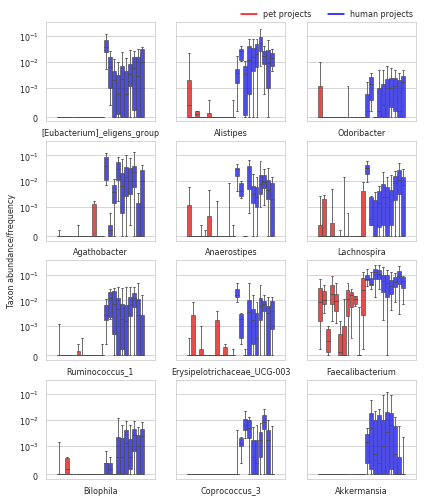

In [26]:
sf = ['A','B','C','D','E','F']
sf_ind = 0
for i in range(1,6):
    data_tax = data.get_taxa(i,True)
    x = list(mwres.loc[(mwres.level==i)&(mwres.rj_holm==True),:].sort_values('corr_pvalue_holm').full_tax_name)
    data_phylums = data_tax[x]
    df = data_phylums.merge(data.info,left_index=True,right_index=True)
    df_melted = pd.melt(df,id_vars=['project_name','Host','Host_type'])
    df_melted['last_tax'] = df_melted.variable.apply(lambda x: x.split(';')[-1])
    if (i==4):
        name = 'pics/Figure2.pdf'
    else:
        name = 'pics/SupplementaryFigure2'+sf[sf_ind]+'.pdf'
        sf_ind = sf_ind + 1
    draw2(df_melted,x)
    plt.savefig(name, dpi = 300, bbox_inches='tight')